Loading crops...:   0%|          | 0/1315 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/this_experiment/dataset.py:92: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/torch/csrc/utils/tensor_numpy.cpp:199.)
  torch.from_numpy(


torch.Size([1, 128, 128])
torch.bool


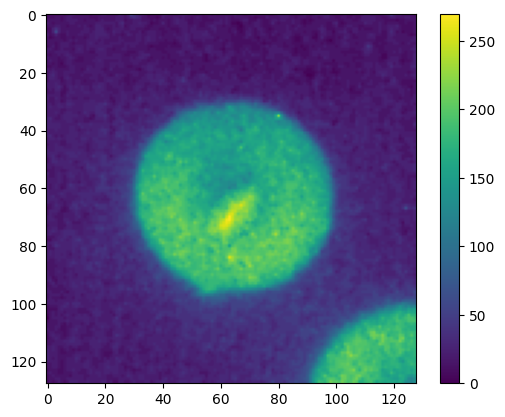

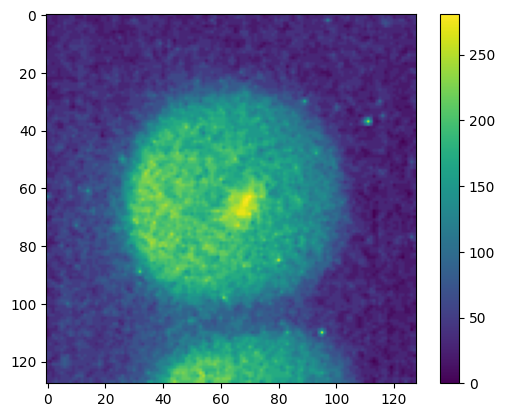

torch.Size([514])
torch.Size([494])
0.5
0.48582995951417


In [1]:
from this_experiment.models import CPFeatures
from this_experiment.dataset import CellCrops
from this_experiment.transforms import add_ellipse_random_placement

from pathlib import Path
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
import torch

import matplotlib.pyplot as plt

DSET_PATH = Path("/data/dataset/fl_dataset/healthy_train/raw")
dset = CellCrops(DSET_PATH, transforms=None, ext=None, load_to_gpu=None, set_size=128, debug=False)

cp = CPFeatures([2, 32, 64, 128, 256], 3, 3, diam_mean=70, pretrained_path="/model/cyto2torch_0")
#outp_ = cp((dset[0] / 255.)[None,].expand(-1,2,-1,-1))[0]
#print(outp_.shape)

img = dset[0]
img, mask = add_ellipse_random_placement(img, (60,70), (60,70), (10,20), (5,10), (0, 1.6))
print(img.shape)
print(mask.dtype)

def subsample(X, m):
    r"""
    Inputs:

        :X: (N_samples, N_features)

        :m: int

    Returns:
        (m, N_features)
    """
    N_samples = X.shape[0]
    sample_idxs = (torch.rand(m) * N_samples).floor().long()

    return X[sample_idxs]

def test_classifier_forward():
    r"""
    """

    def get_good_bad(img_ok, img_prebad):
        r"""
        Ret X,y balanced dataset.
        """

        img_bad, mask_bad = add_ellipse_random_placement(img_prebad, (60,70), (60,70), (10,15), (5,10), (0, 1.6),
                                                        scale=100.)
        feats_bad = cp((img_bad / img_bad.max())[None,].expand(-1,2,-1,-1))[0][:,mask_bad].T
        feats_ok = subsample(
                cp((img_ok / img_ok.max())[None,].expand(-1,2,-1,-1))[0].flatten(start_dim=1).T,
                feats_bad.shape[0]
            )
        
        plt.imshow(img_bad[0]); plt.colorbar(); plt.show()

        X = torch.cat([feats_ok, feats_bad], dim=0)
        y = torch.cat([torch.zeros(feats_ok.shape[0]),
                             torch.ones(feats_bad.shape[0])
                             ]).int()

        return X, y

    img_ok = dset[0]
    img_prebad = dset[1]
    X_train, y_train = get_good_bad(img_ok, img_prebad)
    
    img_ok_test = dset[2]
    img_prebad_test = dset[3]
    X_test, y_test = get_good_bad(img_ok_test, img_prebad_test)
    print(y_train.shape)
    print(y_test.shape)

    gp_clf = GaussianProcessClassifier()
    gp_clf.fit(X_train, y_train)
    print(gp_clf.score(X_test, y_test))
    
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    print(rf_clf.score(X_test, y_test))

test_classifier_forward()


In [60]:
from sklearn.datasets import make_classification
from sklearn.gaussian_process import GaussianProcessClassifier

n_total = 1000
n_eval = 50

X, y = make_classification(random_state=1, 
                           n_samples=n_total, 
                           n_informative=2, 
                           n_redundant=0, 
                           n_repeated=0, 
                           n_classes=2, 
                           n_clusters_per_class=1,
                           n_features=2)

X_tr, y_tr = X[:-n_eval], y[:-n_eval]
X_ev, y_ev = X[-n_eval:], y[-n_eval:]

print("X_tr : {}".format(X_tr.shape))
print("X_ev : {}".format(X_ev.shape))

clf = GaussianProcessClassifier(
        kernel=(
                    ConstantKernel(kernel_constant) * \
                    RBF(length_scale=kernel_lengthscale)
        )
)

clf.fit(X_tr, y_tr)
clf.score(X_ev, y_ev)

print(clf.kernel_)

X_tr : (950, 2)
X_ev : (50, 2)
1**2 * RBF(length_scale=1)


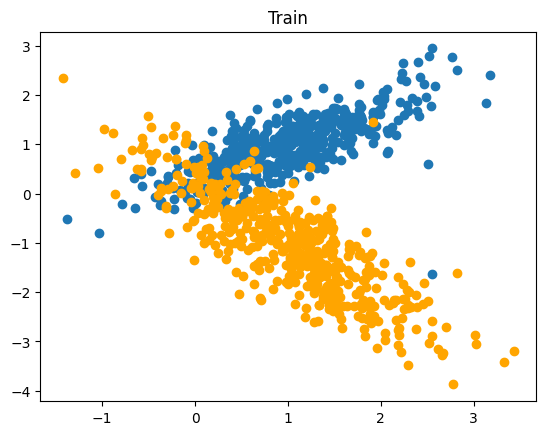

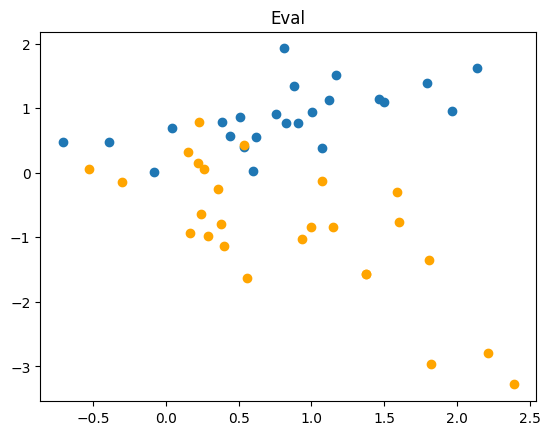

In [61]:
def viz_xy(X, y, title=None):
    plt.scatter(X[y==0][:,0], X[y==0][:,1])
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='orange')
    plt.title(title)
    plt.show()
    
viz_xy(X_tr, y_tr, title="Train")
viz_xy(X_ev, y_ev, title="Eval")